# Water Hack Week 2020: Accessing Hydrology and Climatology Data Usin Python

Taher Chegini

University of Houston

September 3, 2020

## Introdction

Hydrology and Climatology Dataset:
- Staggering amount of high-quality publicly available datasets
- Linking databases based on hydrology and climatology relations
- Data subsetting and transfering
- Common data pre-processing tasks
- Required storage

My journey began [here](https://waterservices.usgs.gov/rest/DV-Test-Tool.html).

## Terminology

[Web service](https://en.wikipedia.org/wiki/Open_Geospatial_Consortium):
> A server running on a computer device, listening for **requests** at a particular port over a network, serving web documents (HTML, JSON, XML, images), and creating web applications services, which serve in solving specific domain problems over the Web (WWW, Internet, HTTP)

[OGC](https://en.wikipedia.org/wiki/Open_Geospatial_Consortium):
> The Open Geospatial Consortium (OGC), an international voluntary consensus standards organization, originated in 1994. In the OGC, more than 500 commercial, governmental, nonprofit and research organizations worldwide collaborate in a consensus process encouraging development and implementation of open standards for geospatial content and services, sensor web and Internet of Things, GIS data processing and data sharing.

[RESTful](https://en.wikipedia.org/wiki/Representational_state_transfer):
> Representational state transfer (REST) is a software architectural style that defines a set of constraints to be used for creating Web services. Web services that conform to the REST architectural style, called RESTful Web services, provide interoperability between computer systems on the internet. RESTful Web services allow the requesting systems to access and manipulate textual representations of Web resources by using a uniform and predefined set of stateless operations.

[WMS](https://en.wikipedia.org/wiki/Web_Map_Service):
> A Web Map Service (WMS) is a standard protocol developed by the Open Geospatial Consortium in 1999 for serving georeferenced map images over the Internet. These images are typically produced by a map server from data provided by a GIS database.

[WFS](https://en.wikipedia.org/?curid=405742):
> In computing, the Open Geospatial Consortium Web Feature Service (WFS) Interface Standard provides an interface allowing requests for geographical features across the web using platform-independent calls. One can think of geographical features as the "source code" behind a map, whereas the WMS interface or online tiled mapping portals like Google Maps return only an image, which end-users cannot edit or spatially analyze.

## Web services in the hydrology community

Pros:
- Many common pre-processing tasks can be performed on the server-side
- Ability to filter the data and only store the required values

Cons:
- Relatively young and constantly evolving
- Differences in implementation of web services provided by different organizations
- Dealing with server-side issue can be challenging (e.g., 500s error)

## [Hydrodata](https://hydrodata.readthedocs.io/en/latest/)

It is a stack of Python libraries designed to aid in watershed analysis through RESTful-, WMS-, and WFS-based web services. Currently, it only includes hydrology and climatology data within the US. Some of the major capabilities of Hydrodata are:

- Easy access to many web services for subsetting data and returning them as masked `xarrays` or `GeoDataFrames`.
- Splitting the requests into smaller chunks under-the-hood since web services limit the number of items per request. So the only bottleneck for subsetting the data is the local available memory.
- Navigating and subsetting data from the NHDPlus (MR and HR) database using web services.
- Cleaning up the vector NHDPlus data, fixing some common issues, and computing flow accumulation.
- A URL inventory of some of the popular (and tested) web services.
- Many other utilities for manipulating the data and visualization.

![hydrodata](https://raw.githubusercontent.com/cheginit/hydrodata/develop/docs/_static/hydrodata_logo_text.png)

- [Hydrodata](https://github.com/cheginit/hydrodata): Access NWIS, HCDN 2009, NLCD, and SSEBop databases
- [PyGeoOGC](https://github.com/cheginit/pygeoogc): Query data from any ArcGIS RESTful-, WMS-, and WFS-based services
- [PyGeoUtils](https://github.com/cheginit/pygeoutils): Convert responses from PyGeoOGC\'s supported web services to datasets
- [PyNHD](https://github.com/cheginit/pynhd): Access NLDI and WaterData web services for navigating the NHDPlus database
- [Py3DEP](https://github.com/cheginit/py3dep): Access topographic data through the 3D Elevation Program (3DEP) web service
- [PyDaymet](https://github.com/cheginit/pydaymet): Access the Daymet database for daily climate data


# Hydrodata in Action



Let's start by working with [NLDI](https://labs.waterdata.usgs.gov/about-nldi/index.html) and [WaterData](https://labs.waterdata.usgs.gov/geoserver/web/) services.

In [1]:
from pynhd import NLDI, WaterData
import pynhd as nhd
import cmocean.cm as cmo

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
nldi = NLDI()

Get ComIDs that are within the watershed by navigating the flowlines from the watershed outlet toward its headwater.

In [4]:
args = {
    "fsource": "nwissite",
    "fid": "USGS-01031500",
    "navigation": "upstreamTributaries",
    "source": "flowlines",
    "distance": 1000,
}
comids = nldi.navigate_byid(**args).nhdplus_comid.tolist()

Get the tributaries of the watershed from NHDPlus.

In [5]:
wd = WaterData("nhdflowline_network")
flowlines = wd.byid("comid", comids)

Now, let's explore the available catchment-scale attributes for NHDPlus database from USGS's [ScienceBase-Cataloge](https://www.sciencebase.gov/catalog/item/5669a79ee4b08895842a1d47).

Let's use "Estimated Mean Annual Natural Groundwater Recharge" database from https://www.sciencebase.gov/catalog/item/56f97577e4b0a6037df06b5a.

Note that instead of browsing online you can use ``nldi.characteristics_dataframe("", "", "")`` where the first varibale is characteristics type, the second one is characteristics IDs, and the third one is the file name. Passing empty arguments throws an error and show all the available options.

In [6]:
char = "CAT_RECHG"
# local = nldi.getcharacteristic_byid(comids, "local", char_ids=char)
# local.to_parquet(f"data/{char}.parquet")

Since this function usually takes a while to get the data, I have already ran the it once and stored data as a parquet file. So let's load the file instead.

In [7]:
import pandas as pd

local = pd.read_parquet(f"data/{char}.parquet")

Prepare the flowlines for performing flow accumulation then accumulate `CAT_RECHG` characteristic through the flowlines.

In [8]:
area = "areasqkm"

flw = nhd.prepare_nhdplus(flowlines, 0, 0, purge_non_dendritic=False)
flw = flw.merge(local[char], left_on="comid", right_index=True)

def runoff_acc(qin, q, a):
    return qin + q * a

flw_r = flw[["comid", "tocomid", char, area]]
runoff = nhd.vector_accumulation(flw_r, runoff_acc, char, [char, area])

def area_acc(ain, a):
    return ain + a

flw_a = flw[["comid", "tocomid", area]]
areasqkm = nhd.vector_accumulation(flw_a, area_acc, area, [area])

runoff /= areasqkm

Get all the catchments' geometries within the watershed.

In [9]:
wd = WaterData("catchmentsp")
catchments = wd.byid("featureid", comids)

Add the accumulated characteristic as a new column and plot the results.

In [10]:
c_local = catchments.merge(local, left_on="featureid", right_index=True)
c_acc = catchments.merge(runoff, left_on="featureid", right_index=True)

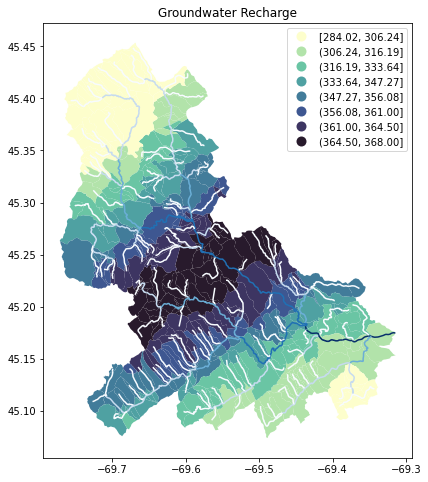

In [11]:
ax = c_local.plot(column=char, cmap=cmo.deep, scheme='quantiles', k=8, legend=True, figsize=(8, 8))
flw.plot(ax=ax, column="streamorde", cmap="Blues", scheme='fisher_jenks')
ax.set_title("Groundwater Recharge");

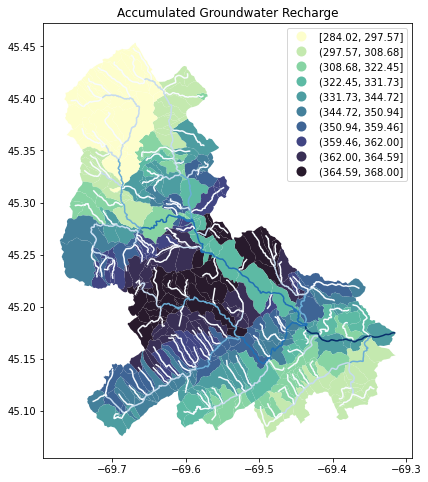

In [12]:
ax = c_acc.plot(column=f"acc_{char}", cmap=cmo.deep, scheme='quantiles', k=10, legend=True, figsize=(8, 8))
flw.plot(ax=ax, column="streamorde", cmap="Blues", scheme='fisher_jenks')
ax.set_title("Accumulated Groundwater Recharge");

Now, let's get the main river flowlines and get DEM for its local catchments.

In [13]:
args = {
    "fsource": "nwissite",
    "fid": "USGS-01031500",
    "navigation": "upstreamMain",
    "source": "flowlines",
    "distance": 1000,
}
comids_main = nldi.navigate_byid(**args).nhdplus_comid.tolist()

Since 3DEP service is down at this time, we'll use [OpenTopography](https://opentopography.org/) for getting topography data.

In [14]:
from pygeoogc import RetrySession
import pygeoutils as geoutils

In [15]:
basin = catchments.unary_union
bbox = basin.bounds
bbox_query = dict(zip(("west", "south", "east", "north"), bbox))

In [16]:
wd = WaterData("catchmentsp")
catchments_main = wd.byid("featureid", comids_main)

In [17]:
url = "https://portal.opentopography.org/API/globaldem"
payload = {
    "demtype": "SRTMGL1",
    **bbox_query,
    "outputFormat": "GTiff"
}
s = RetrySession()
r = s.get(url, payload)
dem = geoutils.gtiff2xarray({"dem": r.content}, catchments_main.unary_union, "epsg:4326")
dem.attrs["units"] = "meters"

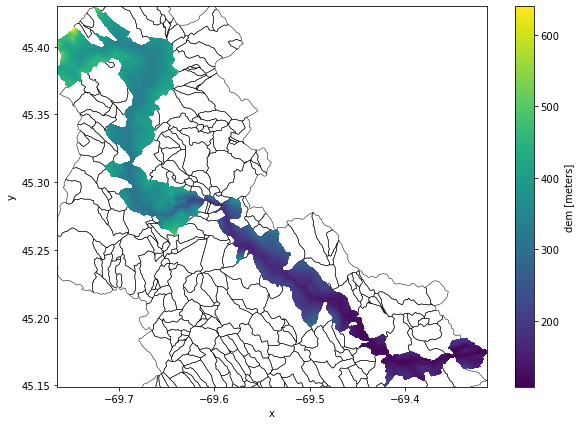

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
catchments.plot(ax=ax, facecolor="none", edgecolor="k", lw=0.5)
dem.plot(ax=ax);